<a href="https://colab.research.google.com/github/Vicinius/nepal-earthquake-prediction/blob/main/RandomForest_FeatureEngineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 16

#Pré-processamento e model selection
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score


time: 13.8 ms (started: 2021-04-07 17:32:47 +00:00)


In [ ]:
DATA_DIR = Path('..','content')

train_values = pd.read_csv(DATA_DIR / 'train_values.csv', index_col='building_id')
train_labels = pd.read_csv(DATA_DIR / 'train_labels.csv', index_col='building_id')
test_values = pd.read_csv(DATA_DIR / 'test_values.csv')
submission_format = pd.read_csv(DATA_DIR / 'submission_format.csv', index_col='building_id')

time: 907 ms (started: 2021-04-07 17:32:48 +00:00)


In [ ]:
print(f'Train shape {train_values.shape}')
print(f'Test shape {test_values.shape}')
print(f'Labels shape {train_labels.shape}')
print(f'Submission shape {submission_format.shape}')

Train shape (260601, 38)
Test shape (86868, 39)
Labels shape (260601, 1)
Submission shape (86868, 1)
time: 7.19 ms (started: 2021-04-07 17:32:49 +00:00)


In [ ]:
submission_format.head()

,damage_grade
building_id,
300051,1
99355,1
890251,1
745817,1
421793,1


time: 11.9 ms (started: 2021-04-07 17:32:49 +00:00)


In [ ]:
train_values.info()
#Algumas colunas não são numéricas e sim,
# categóricas e devem ser tratadas


<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-

In [ ]:
train = pd.merge(train_values, train_labels, on='building_id')
train.head()
print(f'NEW Train shape {train.shape}')
print(f'OLD Train shape {train_values.shape}')


NEW Train shape (260601, 39)
OLD Train shape (260601, 38)
time: 271 ms (started: 2021-04-07 17:32:49 +00:00)


In [ ]:
test_values.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0
2,890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0
4,421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


time: 62.3 ms (started: 2021-04-07 17:32:49 +00:00)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Damage')

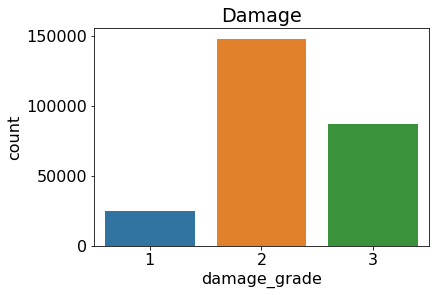

time: 231 ms (started: 2021-04-07 17:32:49 +00:00)


In [ ]:
#plt.figure()
sns.countplot(train_labels['damage_grade'])
plt.title('Damage')

In [ ]:
#junta treino e teste para mexermos nas características
df_full = pd.concat([train, test_values], axis=0).reset_index(drop=True)
df_full.shape

df_full.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,building_id
0,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3.0,NaN
1,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2.0,NaN
2,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3.0,NaN
3,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2.0,NaN
4,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3.0,NaN


time: 268 ms (started: 2021-04-07 17:32:49 +00:00)


In [ ]:
train.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3


time: 68.5 ms (started: 2021-04-07 17:32:50 +00:00)


In [ ]:
#função que combina as colunas novas geradas a partir das características
def merge_by_concat(df1, df2, merge_on):
  merged_gf = df1[merge_on]
  merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
  new_columns = [col for col in list(merged_gf) if col not in merge_on]
  df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
  return df1

time: 4.91 ms (started: 2021-04-07 17:32:50 +00:00)


"Frequency encoding technique" para as colunas que temos variáveis categoricas, que poderiam causar sérios problemas no dataset


In [ ]:
freq_cols = ['land_surface_condition','foundation_type','roof_type',
             'ground_floor_type','other_floor_type','position','plan_configuration',
             'legal_ownership_status']

def frequency_encode(cols, df, self_encoding=False):
  for c in cols:
    fq_dict = df[c].value_counts().to_dict()
    if self_encoding:
      df[c] = df[c].map(fq_dict)
    else:
      df[c+'fq_enc'] = df[c].map(fq_dict)
  return df
df_full_freq = frequency_encode(freq_cols, df_full, self_encoding=True)

time: 479 ms (started: 2021-04-07 17:32:50 +00:00)


In [ ]:
train_new = df_full[:train_values.shape[0]]
test_new = df_full[train_values.shape[0]:]

time: 2.3 ms (started: 2021-04-07 17:32:50 +00:00)


Para evitar colunas com pesos fora de escala, é aplicado um StandardScaler() para valores do tipo geográficos que tem muitos dígitos ficarem numa escala melhor com valores binários.

In [ ]:
scaler = StandardScaler()

features = train_new.drop(columns=['building_id','damage_grade'], axis=1).columns

X = train_new.drop(columns=['building_id','damage_grade'], axis=1)
test_new = test_new.drop(columns=['building_id','damage_grade'], axis=1)

y = train_new['damage_grade']

sc = scaler.fit(X)
temp_train_X = sc.transform(X)
test_scaled = sc.transform(test_new)

X = pd.DataFrame(temp_train_X, columns=features)
test = pd.DataFrame(test_scaled, columns=features)

time: 405 ms (started: 2021-04-07 17:32:50 +00:00)


In [ ]:
def check_model_f1_score(model):
  model.fit(X_train, y_train)
  test_y_pred = model.predict(X_test)
  return f1_score(y_test, test_y_pred, average='micro')
  

time: 2.93 ms (started: 2021-04-07 17:32:51 +00:00)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

time: 111 ms (started: 2021-04-07 17:32:51 +00:00)


In [ ]:
#props do f1_score: sklearn.metrics.f1_score(y_true, y_pred, average=''... ETC

#average{‘micro’, ‘macro’, ‘samples’,’weighted’, ‘binary’} or None, default=’binary’

#y_true: 1d array-like, or label indicator array / sparse matrix
#Ground truth (correct) target values.

#y_pred: 1d array-like, or label indicator array / sparse matrix
#Estimated targets as returned by a classifier.

time: 1.86 ms (started: 2021-04-07 17:32:51 +00:00)


In [ ]:
#y.head(), y_train.head(), X_train.head(), X_test.head()

time: 1.1 ms (started: 2021-04-07 17:32:51 +00:00)


In [ ]:
!pip install ipython-autotime

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.85 s (started: 2021-04-07 17:32:51 +00:00)


In [ ]:
from sklearn.linear_model import LogisticRegression


lr = LogisticRegression(multi_class='multinomial')
lr_score = check_model_f1_score(lr)

lr = lr.fit(X,y)
lr = lr.predict(X) 

#predictionslr_predicted.score(X, y)

print('LogisticRegression: ', lr_score)

LogisticRegression:  0.5841700668960489
time: 16.7 s (started: 2021-04-07 17:33:18 +00:00)


criterion{“gini”, “entropy”}, default=”gini”
splitter{“best”, “random”}, default=”best”



In [ ]:
pip install --upgrade sklearn


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


dc = DecisionTreeClassifier()
#dc_score = check_model_f1_score(dc)

#print(dc.tree_.max_depth)
#print(dc.tree_.n_classes)

#predictionsdc = dc.fit(X_train,y_train)
#y_pred = predictionsdc.predict(X_test)
#dc_score = check_model_f1_score(predictionsdc)

dc_score = check_model_f1_score(dc)

result_y = predictionsdc.predict(test_new)


#help(dc.tree_)
#tree.plot_tree(dc)
print('Decision tree após o feature engineering: ', dc_score)


Decision tree após o feature engineering:  0.6566940816822502
time: 2.3 s (started: 2021-04-07 17:55:00 +00:00)


In [ ]:
result_y.size

86868

time: 7.12 ms (started: 2021-04-07 17:55:11 +00:00)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rc = RandomForestClassifier()
rc_score = check_model_f1_score(rc)

print('Random forest após o feature engineering: ', rc_score)


Random forest após o feature engineering:  0.7170284340184956
time: 46.3 s (started: 2021-04-07 17:34:55 +00:00)


In [ ]:
rc = rc.fit(X,y)
rc = rc.predict(X)

In [ ]:
#predictions.size

#alterar aqui a predição de cada método acima, LR, DT, RF...
new_predictions = result_y



time: 1.52 ms (started: 2021-04-07 17:55:55 +00:00)


In [ ]:
submission_format.size

86868

time: 6.95 ms (started: 2021-04-07 17:56:01 +00:00)


In [ ]:
new_predictions.size

86868

time: 3.8 ms (started: 2021-04-07 17:56:29 +00:00)


In [ ]:
submission_format = pd.read_csv(DATA_DIR / 'submission_format.csv', index_col='building_id')


my_submission = pd.DataFrame(data=new_predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

#convertendo float (?) para int 
my_submission['damage_grade'] = my_submission['damage_grade'].astype(int)

my_submission.head()



,damage_grade
building_id,
300051,1
99355,1
890251,1
745817,2
421793,1


time: 42.8 ms (started: 2021-04-07 17:56:32 +00:00)


In [ ]:

my_submission.to_csv('decision_tree01.csv')

time: 122 ms (started: 2021-04-07 17:56:56 +00:00)
